In [1]:
import os

PARQ_F_NAME = "loan_data.parquet"

In [2]:
import findspark
findspark.init()
findspark.find()


'/opt/spark'

In [3]:
# Import PySpark
from pyspark.sql import SparkSession
from pyspark import SparkFiles

In [4]:

# Create SparkSession
spark = SparkSession.builder.appName('session_1').getOrCreate()
df = None

22/08/13 22:25:52 WARN Utils: Your hostname, john-GF65-Thin-10UE resolves to a loopback address: 127.0.1.1; using 192.168.100.2 instead (on interface wlo1)
22/08/13 22:25:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/08/13 22:25:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


    This Step takes ~10 minutes with 20 Mbps connection

In [5]:
files = []

if not os.path.exists(PARQ_F_NAME):

    urls = ["https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/aa442e64-ba87-4193-9b14-552a99be78a5/download/public_150k_plus_220703.csv",
            "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/18ee3875-8a4c-447b-a56c-f8c04506c0b5/download/public_up_to_150k_1_220703.csv",
            "https://data.sba.gov/dataset/8aa276e2-6cab-4f86-aca4-a7dde42adf24/resource/b7db2262-6eb8-4566-9fe4-c8f4f9235754/download/public_up_to_150k_2_220703.csv"]

    for url in urls:
        spark.sparkContext.addFile(url)
        file = url.split('/')[-1]
        files.append(file)
        print("download complete:", file)


In [6]:
import functools


def unionAll(dfs):
    return functools.reduce(lambda df1, df2: df1.unionByName(
        df2), dfs)


    This step takes ~15 mins to load from .csv 

In [7]:
if not os.path.exists(PARQ_F_NAME):
    from pyspark.sql.functions import to_date, col
    print(files)
    dfs = []
    for file in files:
        df_ = spark.read.option("quote", "\"")\
            .option("escape", "\"")\
            .option("mode", "DROPMALFORMED")\
            .option("inferSchema", "true")\
            .csv("file://"+SparkFiles.get(file),
                 header=True)\
            .withColumn("DateApproved", to_date(col("DateApproved"),"dd/MM/yyyy"))
        print("shape:", (df_.count(), len(df_.columns)))
        dfs.append(df_)
    df = unionAll(dfs)


In [8]:
if not os.path.exists(PARQ_F_NAME):
    df.write.parquet(PARQ_F_NAME)
else:
    df = spark.read.parquet(PARQ_F_NAME)

In [9]:
df.dtypes

[('LoanNumber', 'bigint'),
 ('DateApproved', 'date'),
 ('SBAOfficeCode', 'int'),
 ('ProcessingMethod', 'string'),
 ('BorrowerName', 'string'),
 ('BorrowerAddress', 'string'),
 ('BorrowerCity', 'string'),
 ('BorrowerState', 'string'),
 ('BorrowerZip', 'string'),
 ('LoanStatusDate', 'string'),
 ('LoanStatus', 'string'),
 ('Term', 'int'),
 ('SBAGuarantyPercentage', 'int'),
 ('InitialApprovalAmount', 'double'),
 ('CurrentApprovalAmount', 'double'),
 ('UndisbursedAmount', 'double'),
 ('FranchiseName', 'string'),
 ('ServicingLenderLocationID', 'int'),
 ('ServicingLenderName', 'string'),
 ('ServicingLenderAddress', 'string'),
 ('ServicingLenderCity', 'string'),
 ('ServicingLenderState', 'string'),
 ('ServicingLenderZip', 'string'),
 ('RuralUrbanIndicator', 'string'),
 ('HubzoneIndicator', 'string'),
 ('LMIIndicator', 'string'),
 ('BusinessAgeDescription', 'string'),
 ('ProjectCity', 'string'),
 ('ProjectCountyName', 'string'),
 ('ProjectState', 'string'),
 ('ProjectZip', 'string'),
 ('CD', 's

In [10]:
df.head()

22/08/13 22:25:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Row(LoanNumber=3240737102, DateApproved=datetime.date(2020, 11, 4), SBAOfficeCode=455, ProcessingMethod='PPP', BorrowerName='GROWERS EQUIPMENT COMPANY', BorrowerAddress='2695 SW 64TH AVE', BorrowerCity='DAVIE', BorrowerState='FL', BorrowerZip='33314-1204', LoanStatusDate=None, LoanStatus='Exemption 4', Term=24, SBAGuarantyPercentage=100, InitialApprovalAmount=230100.0, CurrentApprovalAmount=230100.0, UndisbursedAmount=0.0, FranchiseName=None, ServicingLenderLocationID=225134, ServicingLenderName='Truist Bank', ServicingLenderAddress='214 N Tryon St', ServicingLenderCity='CHARLOTTE', ServicingLenderState='NC', ServicingLenderZip='28202-1078', RuralUrbanIndicator='U', HubzoneIndicator='N', LMIIndicator='N', BusinessAgeDescription='Existing or more than 2 years old', ProjectCity='DAVIE', ProjectCountyName='BROWARD', ProjectState='FL', ProjectZip='33314-1204', CD='FL-23', JobsReported=30, NAICSCode=423820, Race='Unanswered', Ethnicity='Unknown/NotStated', UTILITIES_PROCEED=None, PAYROLL_PR

    Delete downloaded csv

In [11]:

for file in files:
    path = SparkFiles.get(file)
    if os.path.exists(path):
        os.remove(path)


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [13]:

df.createOrReplaceTempView("DF")


    Loan Amount Analysis

Text(0.5, 1.0, 'State Average vs National Average')

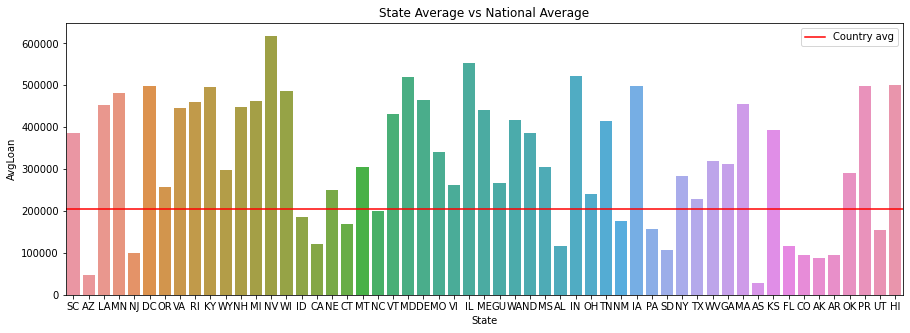

In [14]:
country_avg = spark.sql("select avg(CurrentApprovalAmount) as AvgLoan from DF")\
    .toPandas().loc[0][0]

state_avg_df = spark.sql("select ServicingLenderState as State, avg(CurrentApprovalAmount)" +
                         "as AvgLoan from DF group by ServicingLenderState")\
    .toPandas()

plt.figure(figsize=(15, 5))
sns.barplot(data=state_avg_df, x="State", y="AvgLoan")
plt.axhline(country_avg, label="Country avg", color='r')
plt.legend()
plt.title("State Average vs National Average")


Text(0.5, 1.0, 'Top 5 Avg Loan Cities')

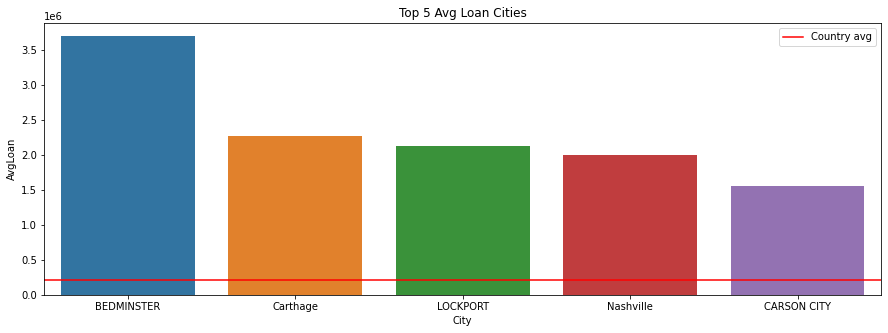

In [15]:
country_avg = spark.sql("select avg(CurrentApprovalAmount) as AvgLoan from DF")\
    .toPandas().loc[0][0]

city_avg_df = spark.sql("select ServicingLenderCity as City, avg(CurrentApprovalAmount)" +
                         "as AvgLoan from DF group by ServicingLenderCity order by AvgLoan desc limit 5")\
    .toPandas().dropna()
city_avg_df = city_avg_df.round()

plt.figure(figsize=(15, 5))
sns.barplot(data=city_avg_df, x="City", y="AvgLoan")
plt.axhline(country_avg, label="Country avg", color='r')
plt.legend()
plt.title("Top 5 Avg Loan Cities")


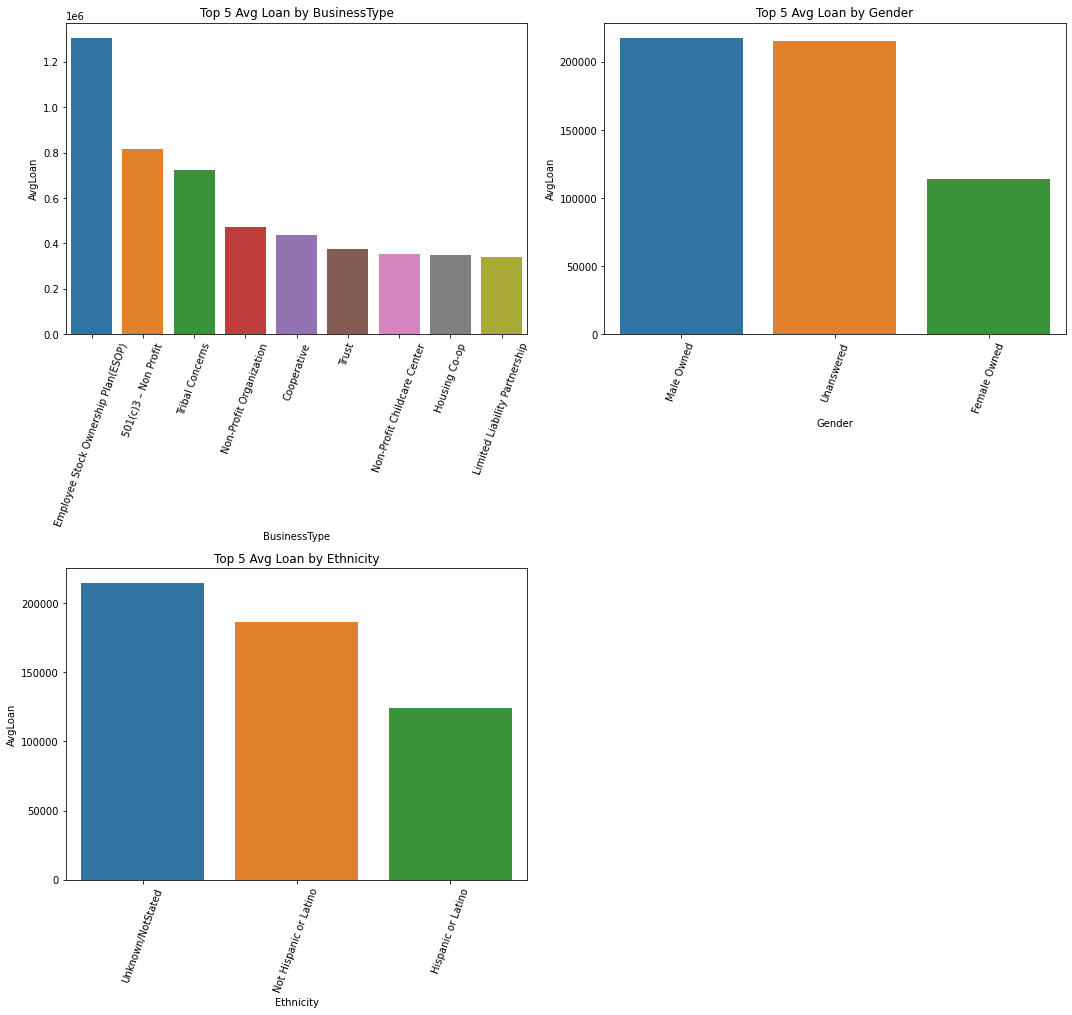

In [16]:


features = ["BusinessType", "Gender", "Ethnicity"]

fig = plt.figure(figsize=(15, 20))
for i, feature in enumerate(features):

    avg_df = spark.sql(f"select {feature}, avg(CurrentApprovalAmount)" +
                       f"as AvgLoan from DF group by {feature} order by AvgLoan desc limit 10")\
        .toPandas().dropna()
    avg_df = avg_df.round()

    axis = plt.subplot(len(features), 2, i+1)
    sns.barplot(data=avg_df, x=feature, y="AvgLoan")
    plt.xticks(rotation=70)
    plt.title(f"Top 5 Avg Loan by {feature}")
plt.tight_layout()


In [17]:
df.stat.corr("JobsReported","CurrentApprovalAmount")


0.8030468758961696

    JobsReported and CurrentApprovalAmount has a linear corelation

In [18]:
import dask.dataframe as dd
import datashader as ds
import holoviews as hv
from holoviews.operation.datashader import datashade
hv.extension('bokeh')
clear_output()

In [19]:
ddf = dd.read_parquet(PARQ_F_NAME, engine="pyarrow")
ddf = ddf.persist()

In [20]:
points  = hv.Points(ddf, ["JobsReported","CurrentApprovalAmount"])

datashade(points,  cnorm="log", aggregator=ds.count())

:DynamicMap   []
   :RGB   [JobsReported,CurrentApprovalAmount]   (R,G,B,A)

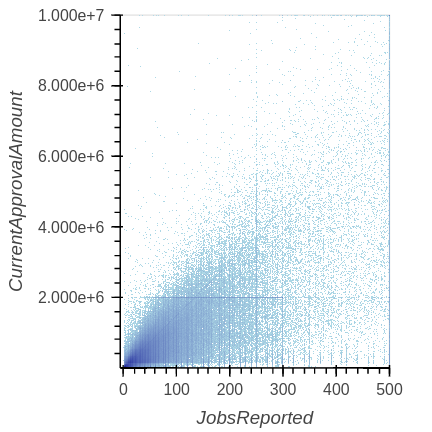

In [22]:
from PIL import Image

im = Image.open('./resources/bokeh_plot.png')
 
display(im)

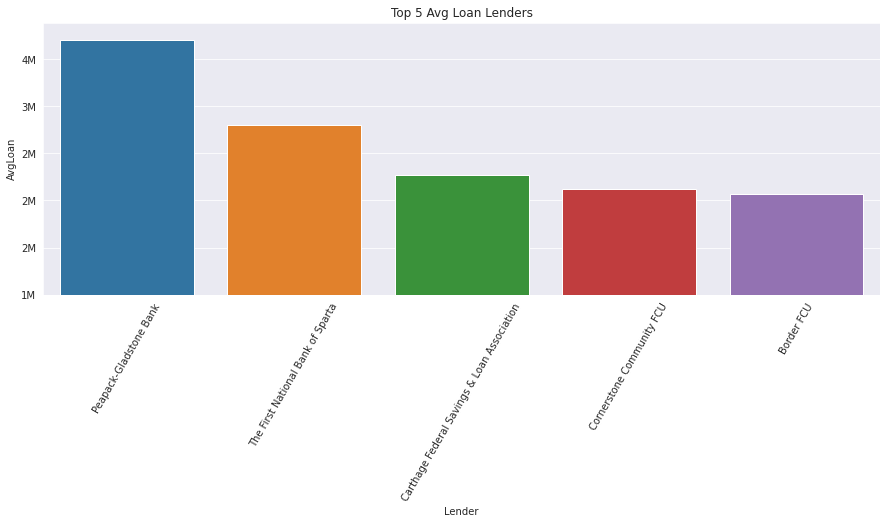

In [222]:
sns.set_style("darkgrid")

lender_avg_df = spark.sql("select ServicingLenderName as Lender, avg(CurrentApprovalAmount)" +
                          "as AvgLoan from DF group by ServicingLenderName order by AvgLoan desc limit 5")\
    .toPandas().dropna()
lender_avg_df = lender_avg_df.round()

plt.figure(figsize=(15, 5))
g = sns.barplot(data=lender_avg_df, x="Lender", y="AvgLoan")

g.set_ylim(bottom=10**6)
ylabels = ['{:,.0f}'.format(x) + 'M' for x in g.get_yticks()/(10**6)]
g.set_yticklabels(ylabels)

plt.title("Top 5 Avg Loan Lenders")
plt.xticks(rotation=60)
sns.set_style("dark")

clear_output()


    City

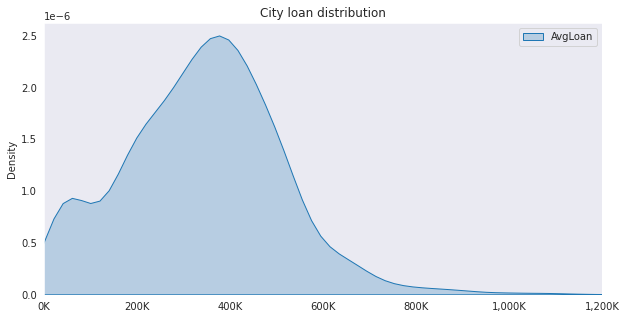

In [223]:
city_avg_df = spark.sql("select avg(CurrentApprovalAmount)" +
                         "as AvgLoan from DF group by ServicingLenderCity ")\
    .toPandas().dropna()
city_avg_df = city_avg_df.round()

plt.figure(figsize=(10, 5))
g = sns.kdeplot(data=city_avg_df, shade=True,)

g.set(xlim = (0,1.2*10**6))
xlabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_xticks()/(10**3)]
g.set_xticklabels(xlabels)

plt.title("City loan distribution")

clear_output()

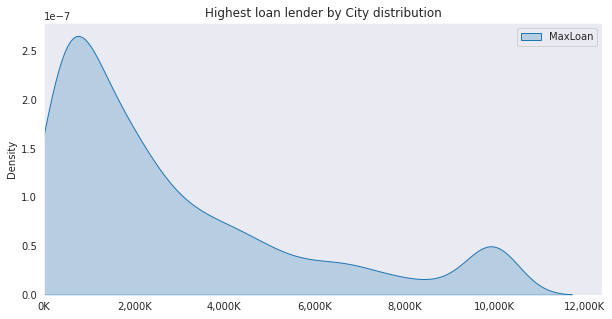

In [224]:
city_max_df = spark.sql("select max(CurrentApprovalAmount)" +
                         "as MaxLoan from DF group by ServicingLenderCity ")\
    .toPandas().dropna()
city_max_df = city_max_df.round()

plt.figure(figsize=(10, 5))
g = sns.kdeplot(data=city_max_df, shade=True,)

g.set_xlim(left=0)
xlabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_xticks()/(10**3)]
g.set_xticklabels(xlabels)

plt.title("Highest loan lender by City distribution")

clear_output()

    Business

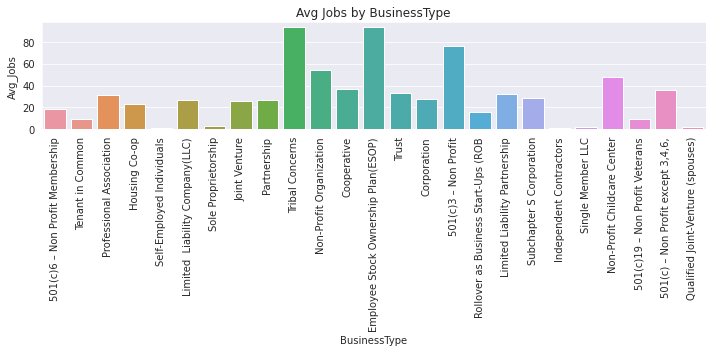

In [230]:

sns.set_style("darkgrid")

fig = plt.figure(figsize=(10, 5))
avg_df = spark.sql("select BusinessType, avg(cast(JobsReported as int))" +
                   "as Avg_Jobs from DF group by BusinessType")\
    .toPandas().dropna()
avg_df = avg_df.round()

g = sns.barplot(data=avg_df, x="BusinessType", y="Avg_Jobs")

plt.xticks(rotation=90)
plt.title(f"Avg Jobs by BusinessType")
plt.tight_layout()
sns.set_style("dark")


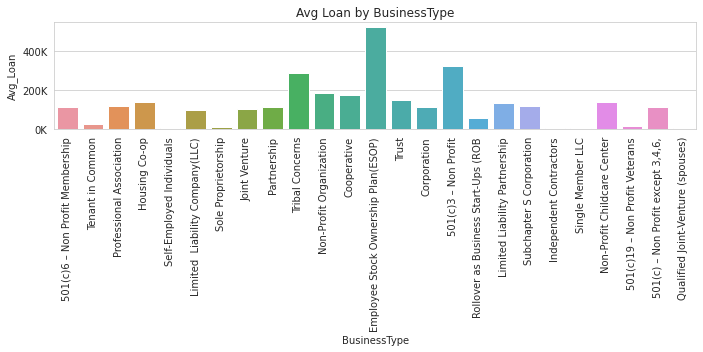

In [231]:

sns.set_style("whitegrid")

fig = plt.figure(figsize=(10, 5))
avg_df = spark.sql("select BusinessType, avg(CurrentApprovalAmount)" +
                   "as Avg_Loan from DF group by BusinessType")\
    .toPandas().dropna()
avg_df = avg_df.round()

g = sns.barplot(data=avg_df, x="BusinessType", y="Avg_Loan")

ylabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/(10**3)]
g.set_yticklabels(ylabels)
plt.xticks(rotation=90)
plt.title(f"Avg Loan by BusinessType")
plt.tight_layout()
sns.set_style("dark")
clear_output()


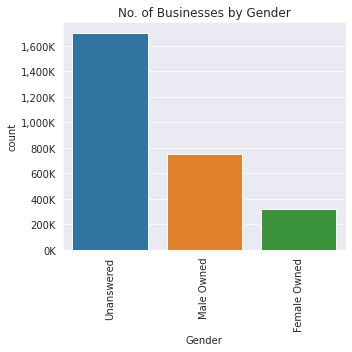

In [232]:

sns.set_style("darkgrid")

fig = plt.figure(figsize=(5, 5))
avg_df = spark.sql("select sq.Gender, count(*) as count from " +
                   "( select Gender from DF ) sq "+
                   "group by sq.Gender ")\
    .toPandas().dropna()
avg_df = avg_df.round()

g = sns.barplot(data=avg_df, x="Gender", y="count")

ylabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/(10**3)]
g.set_yticklabels(ylabels)
plt.xticks(rotation=90)
plt.title(f"No. of Businesses by Gender")
plt.tight_layout()
sns.set_style("dark")
clear_output()


    Date Approved

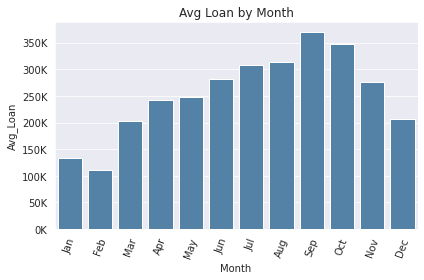

In [309]:
sns.set_style("darkgrid")

avg_month = spark.sql('select date_format(DateApproved, "MMM") as Month,'\
                      + ' max(date_format(DateApproved, "MM")) as m_id,'\
                      + ' avg(CurrentApprovalAmount) as Avg_Loan from DF '\
                      + ' group by Month order by m_id').toPandas()


g = sns.barplot(data=avg_month, x="Month", y="Avg_Loan", color='steelblue')

ylabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/(10**3)]
g.set_yticklabels(ylabels)
plt.xticks(rotation=70)
plt.title(f"Avg Loan by Month")
plt.tight_layout()
sns.set_style("dark")
clear_output()


In [373]:

avg_month = spark.sql('select cast(l36.ym as string) as Month, l36.JobsReported from '
                      + '(select cast(date_format(DateApproved, "yyyyMM") as int) as ym, '
                      + ' avg(JobsReported) as JobsReported from DF'
                      + ' group by ym  order by ym desc limit 36) l36 order by l36.ym').toPandas().dropna()


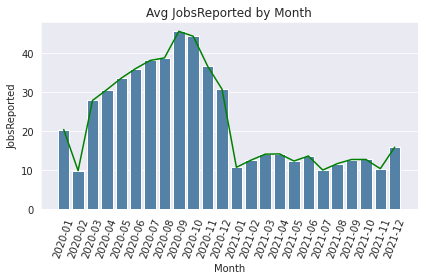

In [374]:
sns.set_style("darkgrid")

g = sns.barplot(data=avg_month, x="Month", y="JobsReported", color='steelblue')
sns.lineplot(data=avg_month, x="Month", y="JobsReported", color='green')
xlabels = [f'{x[:4]}-{x[4:]}' for x in avg_month['Month'].tolist()]
g.set_xticklabels(xlabels)
plt.xticks(rotation=70)
plt.title(f"Avg JobsReported by Month")
plt.tight_layout()
sns.set_style("dark")
clear_output()


In [375]:

avg_month = spark.sql('select cast(l36.ym as string) as Month, l36.Avg_Loan from '
                      + '(select cast(date_format(DateApproved, "yyyyMM") as int) as ym, '
                      + ' avg(CurrentApprovalAmount) as Avg_Loan from DF'
                      + ' group by ym  order by ym desc limit 36) l36 order by l36.ym').toPandas().dropna()


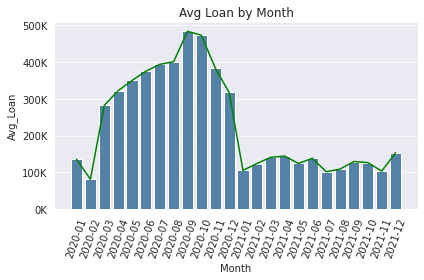

In [376]:
sns.set_style("darkgrid")

g = sns.barplot(data=avg_month, x="Month", y="Avg_Loan", color='steelblue')
sns.lineplot(data=avg_month, x="Month", y="Avg_Loan", color='green')
xlabels = [f'{x[:4]}-{x[4:]}' for x in avg_month['Month'].tolist()]
ylabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_yticks()/(10**3)]
g.set_xticklabels(xlabels)
g.set_yticklabels(ylabels)
plt.xticks(rotation=70)
plt.title(f"Avg Loan by Month")
plt.tight_layout()
sns.set_style("dark")
clear_output()


    LSTM time series prediction model for JobsReported

In [404]:
features_for_prediction = ["InitialApprovalAmount", "CurrentApprovalAmount", "UndisbursedAmount", "JobsReported", "UTILITIES_PROCEED",
                           "PAYROLL_PROCEED", "MORTGAGE_INTEREST_PROCEED", "RENT_PROCEED", "REFINANCE_EIDL_PROCEED", "HEALTH_CARE_PROCEED", "DEBT_INTEREST_PROCEED", ]


In [406]:

avg_qery = " , ".join(
    [f"avg({feature}) as {feature}" for feature in features_for_prediction])


combined_df = spark.sql('select * from '
                    + '(select cast(date_format(DateApproved, "yyyyMMdd") as int) as ymd, '
                      + avg_qery +' from DF '
                      + ' group by ymd  order by ymd desc limit 3000) l3000 order by l3000.ymd').toPandas().dropna()
combined_df.head()


,ymd,InitialApprovalAmount,CurrentApprovalAmount,UndisbursedAmount,JobsReported,UTILITIES_PROCEED,PAYROLL_PROCEED,MORTGAGE_INTEREST_PROCEED,RENT_PROCEED,REFINANCE_EIDL_PROCEED,HEALTH_CARE_PROCEED,DEBT_INTEREST_PROCEED
1,20200105.0,136883.643493,136756.515487,0.0,20.556191,5528.406802,131808.970809,6321.959288,15740.425381,19817.741839,16654.722195,6922.917869
2,20200106.0,84841.568741,84560.879087,0.0,9.852098,8598.635686,81043.696116,4692.507612,21131.797059,4050.968254,23556.184054,348.746190
4,20200205.0,85829.395287,85588.940340,0.0,10.335212,8427.759002,83060.748254,4695.291065,19524.976516,9257.882000,27650.043145,6850.382660
5,20200206.0,76143.602252,75839.784829,0.0,9.355305,11241.841919,72527.865334,4312.453302,12210.624039,11967.119697,7433.853793,1098.303810
6,20200208.0,22330.322124,22315.389054,0.0,2.761240,621.400000,22144.858822,1017.233333,1193.166667,375.000000,241.066667,193.533333


In [407]:
combined_df.set_index('ymd' , inplace=True)

In [408]:
from sklearn.preprocessing import StandardScaler

In [409]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
combined_df_X, combined_df_y = combined_df.drop(
    "JobsReported", axis=1), combined_df[["JobsReported"]]
scaled_X, scaled_y = pd.DataFrame(scaler_X.fit_transform(
    combined_df_X), columns=combined_df_X.columns), pd.DataFrame(scaler_y.fit_transform(combined_df_y), columns=combined_df_y.columns)
combined_df_scaled = scaled_X.join(scaled_y)


In [410]:
def df_to_LSTM_input(df: pd.DataFrame, target=1, window=1, ):
    df_ = pd.DataFrame(df.apply(
        list, axis=1)).reset_index()
    df_ = df_.apply(lambda x: list(df_[0][max(
        int(x.name)-window, 0):int(x.name)].values), axis=1)
    return df_[window:].to_list(), df[target][window:].to_list()


In [411]:
from sklearn.model_selection import train_test_split
window = 2
features = combined_df_scaled.columns.to_list()
X, y = df_to_LSTM_input(
    combined_df_scaled[features], target='JobsReported', window=window)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, shuffle=False)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.30, shuffle=False)

In [ ]:
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import tensorflow as tf

# run for local CUDA memory limiting

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=config)

early_stopping = EarlyStopping(
    min_delta=0.0001,  # minimium amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = Sequential()
model.add(InputLayer((window, len(features))))
model.add(LSTM(32))
model.add(Dropout(0.1))
model.add(Dense(32, 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, 'linear'))

model.summary()


In [413]:

model.compile(loss='mse', optimizer='adam',)

In [414]:
history = model.fit(X_train, y_train, validation_data=(
    X_valid, y_valid), epochs=300, batch_size=2, callbacks=[early_stopping])


Epoch 1/300


2022-08-13 19:31:02.529017: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2022-08-13 19:31:02.920994: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 4s 50ms/step - loss: 1.1272 - val_loss: 0.9142
Epoch 2/300
10/10 [==============================] - 0s 7ms/step - loss: 1.0137 - val_loss: 0.8779
Epoch 3/300
10/10 [==============================] - 0s 9ms/step - loss: 0.9793 - val_loss: 0.8530
Epoch 4/300
10/10 [==============================] - 0s 11ms/step - loss: 0.9307 - val_loss: 0.8267
Epoch 5/300
10/10 [==============================] - 0s 10ms/step - loss: 0.9471 - val_loss: 0.8093
Epoch 6/300
10/10 [==============================] - 0s 9ms/step - loss: 0.9697 - val_loss: 0.7963
Epoch 7/300
10/10 [==============================] - 0s 7ms/step - loss: 0.8599 - val_loss: 0.7876
Epoch 8/300
10/10 [==============================] - 0s 8ms/step - loss: 0.9051 - val_loss: 0.7836
Epoch 9/300
10/10 [==============================] - 0s 9ms/step - loss: 0.8523 - val_loss: 0.7780
Epoch 10/300
10/10 [==============================] - 0s 7ms/step - loss: 0.9069 - val_loss: 0.7789
Epoch 11/300
10/10

Minimum validation loss: 0.7780444622039795


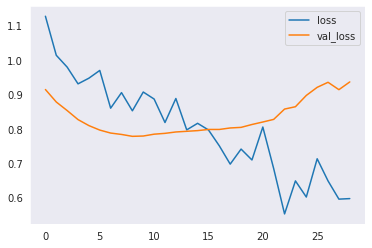

In [415]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))


<AxesSubplot:>

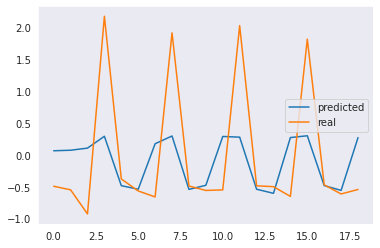

In [416]:
train_predictions = model.predict(X_train).flatten()
sns.lineplot(data=train_predictions, label='predicted')
sns.lineplot(data=y_train, label='real')

<AxesSubplot:>

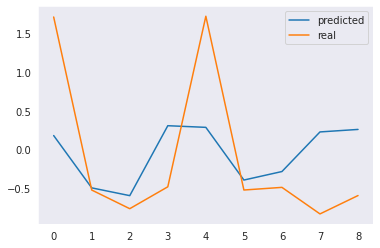

In [417]:
valid_predictions = model.predict(X_valid).flatten()
sns.lineplot(data=valid_predictions, label='predicted')
sns.lineplot(data=y_valid, label='real')

<AxesSubplot:>

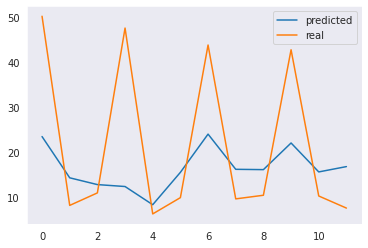

: 

In [418]:
test_predictions = model.predict(X_test).flatten()
test_predictions = scaler_y.inverse_transform(
    pd.DataFrame(test_predictions)).flatten()
test_y = scaler_y.inverse_transform(pd.DataFrame(y_test)).flatten()
sns.lineplot(data=test_predictions, label='predicted')
sns.lineplot(data=test_y, label='real')


In [ ]:
# spark.stop()